# Project - Car Miniatures Wholesaler

### 1) Introduction

In this study, we are going to develop a Sales Analytics project by using the 'Classic Models Sample' database, which contains information on a wholesale company that sells miniatures of cars, motorcicles, ships, trains, among other products. This firm's customers are retailers that acquire miniatures to resell them to the end user.


The objectives of this study are the following: 

- Generate insights that will enable the wholesaler's directors to make assertive decisions;
- Keep track of the firm's KPIs and register them for future use.

How we are going to achieve that:

- By using SQL queries to manipulate and select the data that we want to analyze;
- By creating visualizations with Tableau, so we can interpret the information;


#### The following questions will be answered in this notebook:

- 1) To which countries the company sells more in terms of revenue?


- 2) What was the company' revenue in each year?


- 3) Which were the best-selling product lines in 2003 and 2004?


- 4) Which were the product lines that generated the highest revenues in 2003 and 2004?


- 5) What was the average price for each product line in 2003 and 2004?


- 6) If the company wanted to give a reward to the best employee of each year, how would you choose them?


- 7) The HR department needs to access information about the firm's employees everyday. How can you automate this process?


- 8)  Which customers acquired at least 80.000 dollars in products in 2004?


- 9)  Are there any cases where the total payments made by customers don't match the total value of their orders?

### 1.2) Data Source

The "classicmodels" database is provided by MySQLtutorial website and can be found at: https://www.mysqltutorial.org/mysql-sample-database.aspx/

### 1.3) Relational Schema

This is the 'classic models' database's relational schema. Asterisks (*) indicate the table's  primary key. When there are two asterisks in a single table, it means that this table has a composite primary key:

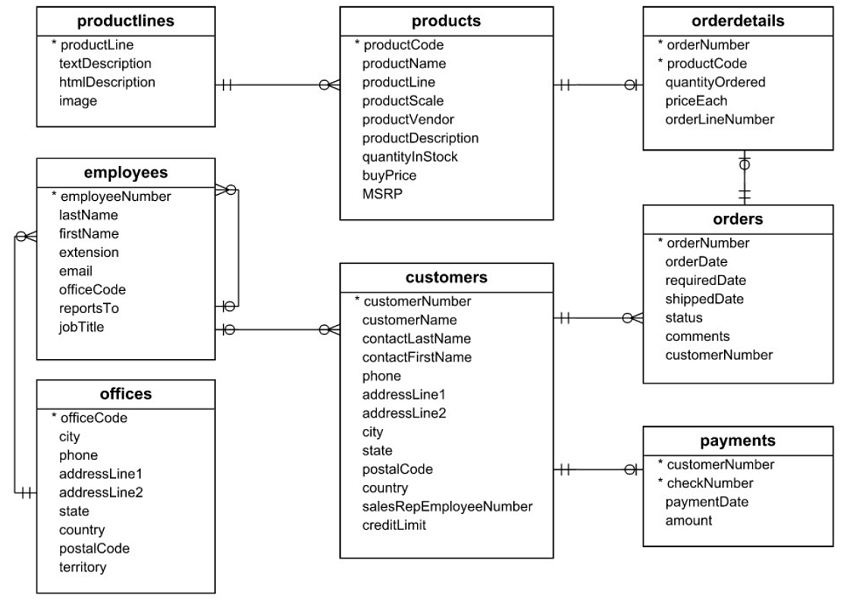

### 1.4) Additional Information

I used MySQL to work with this database. So, I connected MySQL to Python inside Jupyter, so we could program directly in this notebook. Our focus here was to show how to work with a Relational Database Management System to select and export data, and create visualizations with Tableau.

### 2) Initial Analysis

Let's conduct an initial analysis to understand the data:

In [1]:
import os
import mysql.connector
import pandas as pd

We need to get our username and password (environment variables):

In [2]:
db_user=os.environ.get('DB_USER')

db_password=os.environ.get('DB_PASS')

In [3]:
con=mysql.connector.connect(host='localhost',
                           user=db_user,
                           passwd=db_password,
                           database='classicmodels')

Considering that sometimes you may not have a relational schema, it is important to know how to access the database's metadata, which we will do in the following steps of this notebook:

In [6]:
df_tables=pd.read_sql_query('SHOW TABLES FROM classicmodels', con)

df_tables

Tables_in_classicmodels
0               customers
1               employees
2                 offices
3            orderdetails
4                  orders
5                payments
6            productlines
7                products

In [9]:
only_tables=df_tables['Tables_in_classicmodels']

for table in only_tables:
    
    description=pd.read_sql_query('DESCRIBE {}'.format(table), con)
    print(table,'\n')
    print(description,'\n')

customers 

                     Field              Type Null  Key Default Extra
0           customerNumber            b'int'   NO  PRI    None      
1             customerName    b'varchar(50)'   NO         None      
2          contactLastName    b'varchar(50)'   NO         None      
3         contactFirstName    b'varchar(50)'   NO         None      
4                    phone    b'varchar(50)'   NO         None      
5             addressLine1    b'varchar(50)'   NO         None      
6             addressLine2    b'varchar(50)'  YES         None      
7                     city    b'varchar(50)'   NO         None      
8                    state    b'varchar(50)'  YES         None      
9               postalCode    b'varchar(15)'  YES         None      
10                 country    b'varchar(50)'   NO         None      
11  salesRepEmployeeNumber            b'int'  YES  MUL    None      
12             creditLimit  b'decimal(10,2)'  YES         None       

employees 

        

Another relevant factor that we should analyze is how the company registers cancelled orders. Let's check this with the following code:

- Firstly, let's identify which customers cancelled orders:

In [11]:
cancelled_orders="SELECT *\
                FROM orders\
                WHERE status='Cancelled';"

df_cancelled=pd.read_sql_query(cancelled_orders, con)

df_cancelled

orderNumber   orderDate requiredDate shippedDate     status  \
0        10167  2003-10-23   2003-10-30        None  Cancelled   
1        10179  2003-11-11   2003-11-17  2003-11-13  Cancelled   
2        10248  2004-05-07   2004-05-14        None  Cancelled   
3        10253  2004-06-01   2004-06-09  2004-06-02  Cancelled   
4        10260  2004-06-16   2004-06-22        None  Cancelled   
5        10262  2004-06-24   2004-07-01        None  Cancelled   

                                            comments  customerNumber  
0  Customer called to cancel. The warehouse was n...             448  
1  Customer cancelled due to urgent budgeting iss...             496  
2  Order was mistakenly placed. The warehouse not...             131  
3  Customer disputed the order and we agreed to c...             201  
4  Customer heard complaints from their customers...             357  
5  This customer found a better offer from one of...             141

- Let's use customerNumber 131 as an example, because this client cancelled order 10248, as it can be seen above.

The table called 'payments' registers all the amounts paid by the customers. However, we want to to identify if these amounts already exclude cancelled orders or not.

In [14]:
payments_customer131="SELECT py.customerNumber, SUM(py.amount) AS payment_amounts\
                    FROM payments py\
                    WHERE py.customerNumber=131\
                    GROUP BY py.customerNumber;"
                    
df_py_131=pd.read_sql_query(payments_customer131, con)

df_py_131

customerNumber  payment_amounts
0             131        107639.94

According to the information above, customer '131' spent a total of 107,639.94 dollars to acquire products.

- Now, let's analyze this customer's orders: 

In [16]:
orders_customer131="SELECT o.customerNumber, SUM(od.quantityOrdered * od.priceEach) AS orders_amounts\
                    FROM orders o\
                        JOIN\
                    orderdetails od ON o.orderNumber=od.orderNumber\
                    WHERE o.customerNumber=131\
                    GROUP BY o.customerNumber"

df_orders_131=pd.read_sql_query(orders_customer131, con)

df_orders_131

customerNumber  orders_amounts
0             131       149085.15

As we can notice, this customer made orders worth 149,085.15 dollars in total. So, let's calculate the difference between what this client ordered and what it was actually paid.

In [17]:
df_orders_131['orders_amounts']-df_py_131['payment_amounts']

0    41445.21
dtype: float64

The difference is 41,445.21 dollars. In order to confirm that this amount is equivalent to the cancelled order, I used the code below:

In [19]:
amount_cancelled="SELECT od.orderNumber, SUM(quantityOrdered*priceEach) AS cancelled_amount\
                FROM orderdetails od\
                WHERE orderNumber=10248\
                GROUP BY od.orderNumber"

df_amount_cancelled=pd.read_sql_query(amount_cancelled, con)

df_amount_cancelled

orderNumber  cancelled_amount
0        10248          41445.21

As it can be seen above, the values match. This means that the amounts that were registered in the payments table already exclude cancelled orders. This means that we can use this table to have  trustworthy results.

Ok! Now, let's answer the questions!

### 3) Solutions

### 1) To which countries the company sells more in terms of revenue?

Firstly, let's create a table to answer this question:

In [25]:
rev_countries="SELECT c.country, SUM(py.amount) AS total_revenue\
                FROM customers c\
                    JOIN\
                payments py ON c.customerNumber=py.customerNumber\
                GROUP BY c.country\
                ORDER BY SUM(py.amount) DESC"

df_q1=pd.read_sql_query(rev_countries, con)

df_q1

country  total_revenue
0           USA     3040029.52
1         Spain      994438.53
2        France      965750.58
3     Australia      509385.82
4   New Zealand      392486.59
5            UK      391503.90
6         Italy      325254.55
7       Finland      295149.35
8        Norway      270846.30
9     Singapore      261671.60
10       Canada      205911.86
11      Denmark      197356.30
12      Germany      196470.99
13        Japan      167909.95
14      Austria      136119.99
15       Sweden      120457.09
16  Switzerland      108777.92
17      Belgium       91471.03
18  Philippines       87468.30
19      Ireland       49898.27
20    Hong Kong       45480.79

In [26]:
df_q1['country'].count()

21

The firm sells its products to 21 countries. Now, let's visualize the data:

### Chart 1: Revenue per Country in Million USD

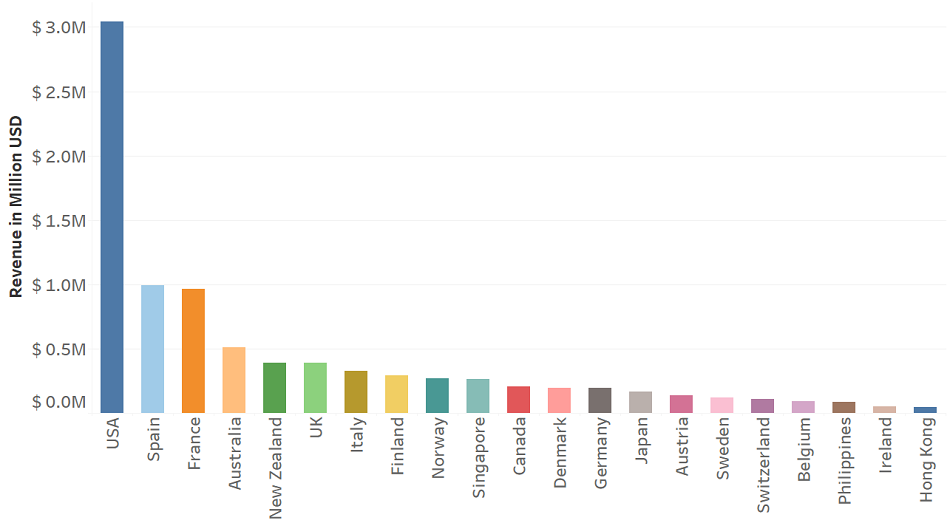

There are too many countries in this dataset. Let's analyze the top 10:

### Chart 2: Revenue per Country in Million USD (Top 10)

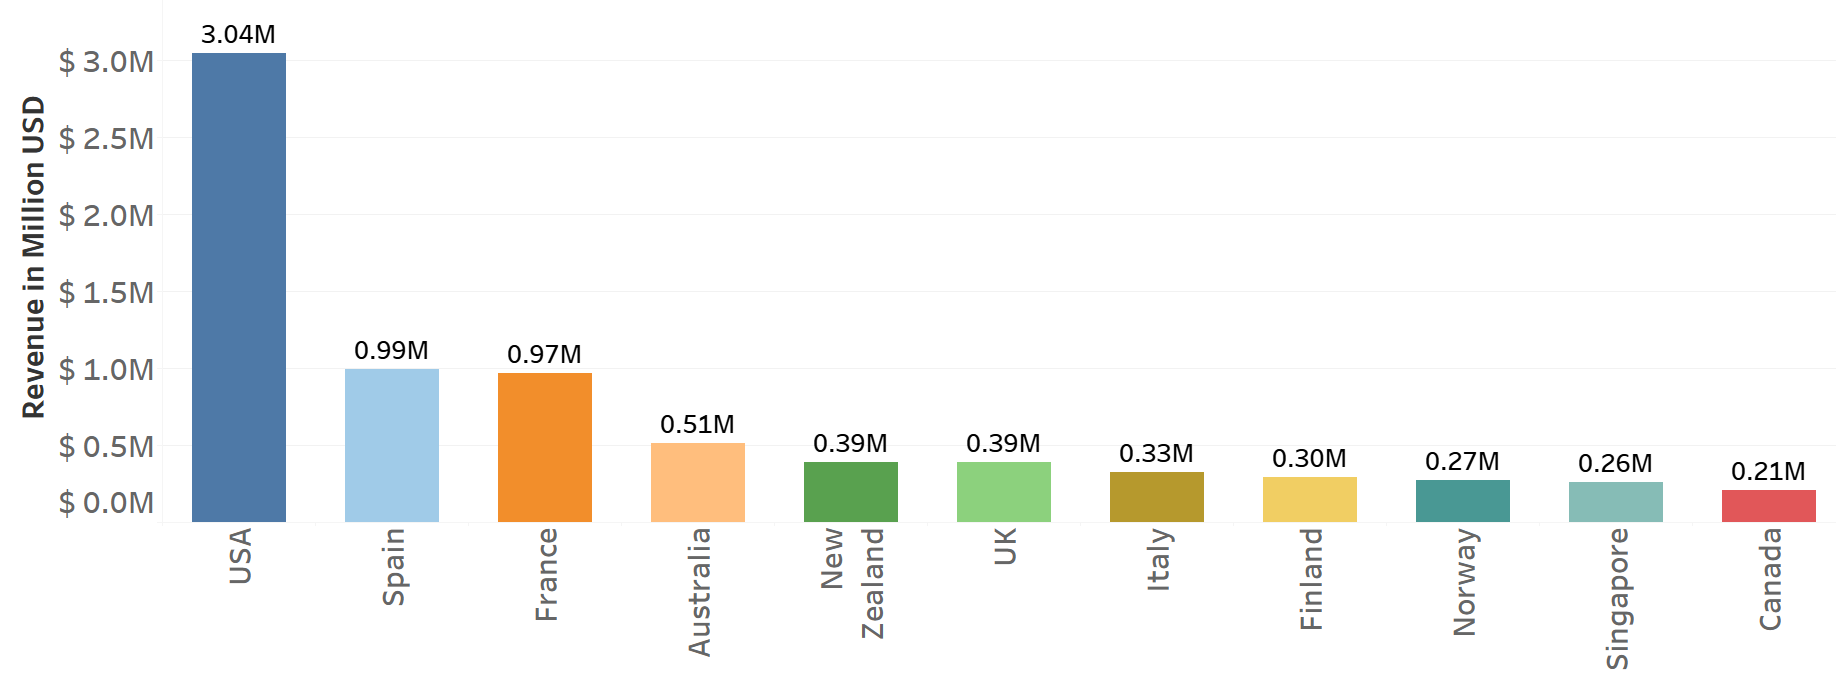

The company's highest revenues are generated by sales to the United States (3,04 million USD), Spain  (0,99 million USD) and France (0,94 million USD). Let's check the representativeness of each country regarding the firm's total sales:

### Chart 3: Representativeness of each country in the Company's Revenue (Top 10)

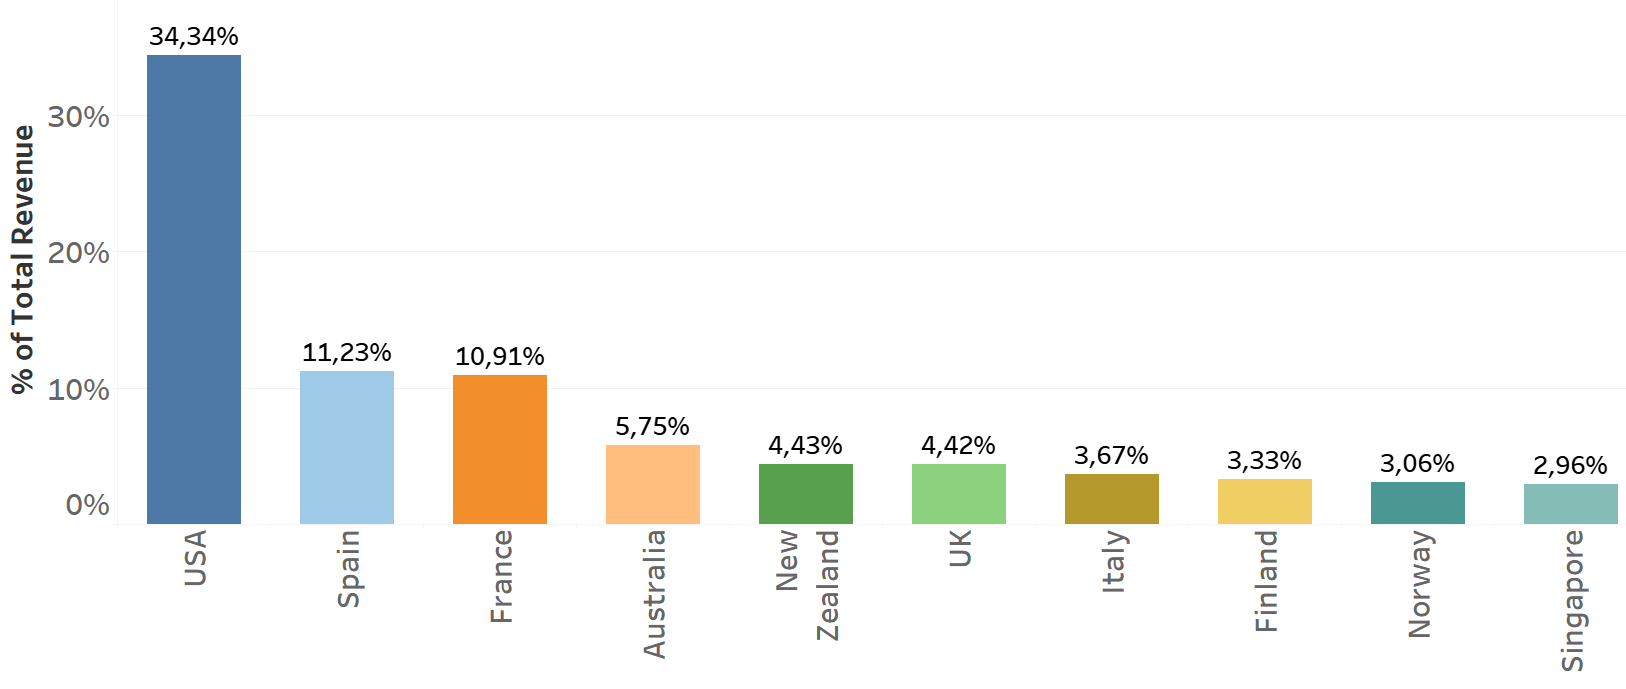

As we can notice, clients from the United States are responsible for 34,34% of the firm's total revenue, which is followed by Spain (11,23%) and France (10,91%). Also, we can visualize these different revenue magnitudes in the following map. Please, consider that larger dots represent higher revenue figures:

### Chart 4: Revenue per Country (Map)

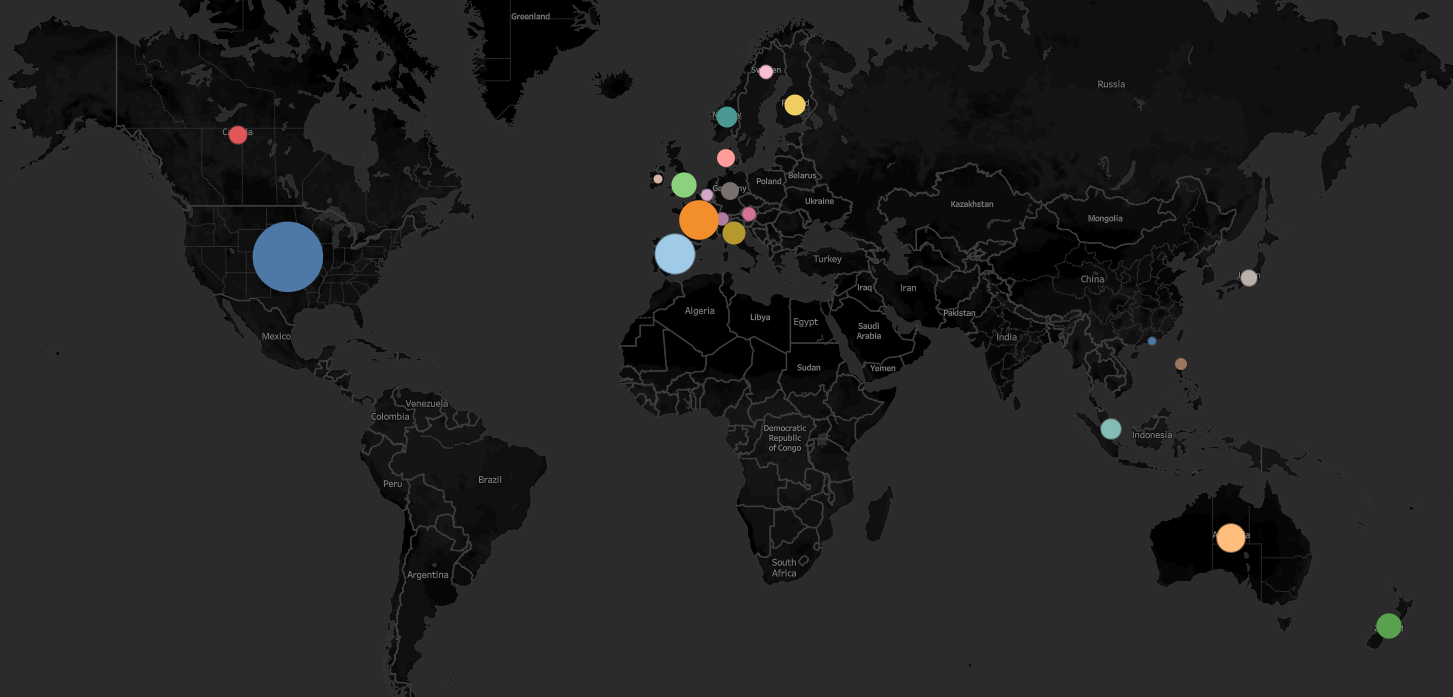

This information will enable the company to manage its stock, logistics and distribution in a more efficient manner. In this sense, we can notice that the majority of the firm's sales are located in the United States and Europe. Outside these locations, the most important countries are Australia (5,75%), New Zealand (4,43%) and Singapore (2,96%).

### Question 2) What was the company' revenue in each year?

In order to calculate the firm's revenue in each year, we have to group the amounts paid by the customers using the payment dates:

In [23]:
revenue_per_year="SELECT YEAR(paymentDate) AS year, SUM(amount) AS revenue\
                FROM payments\
                GROUP BY YEAR(paymentDate)\
                ORDER BY YEAR(paymentDate) ASC;"

df_revenue=pd.read_sql_query(revenue_per_year, con)

df_revenue

year     revenue
0  2003  3250217.70
1  2004  4313328.25
2  2005  1290293.28

Now, I will create a chart, so we can visualize this information. To analyze the chart below, please consider that darker tons of purple represent higher revenues:

### Chart 5) Total Revenue per year

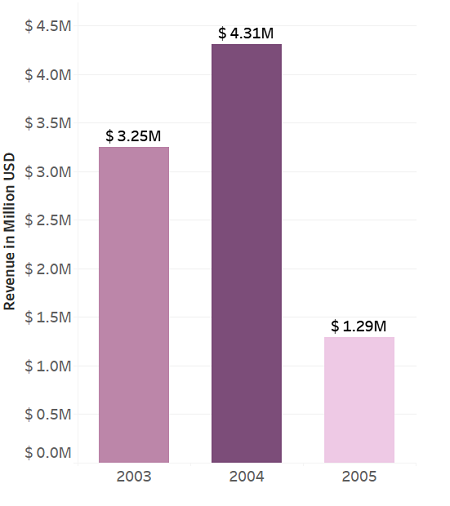

 After visualizing this graph, we can identify that this database presents the company's information from 2003 to 2005. As the discrepancy between 2005 and the other years is substantial, I decided to analyze if the data for 2005 is complete.

In [39]:
is_2005_complete="SELECT *\
                FROM payments\
                WHERE paymentDate LIKE '%2005%'"

df_2005_orders=pd.read_sql_query(is_2005_complete,con)

df_2005_orders

customerNumber  checkNumber paymentDate     amount
0              119      NG94694  2005-02-22   49523.67
1              124     AE215433  2005-03-05  101244.59
2              124      ET64396  2005-04-16   83598.04
3              141     DL460618  2005-05-19   46895.48
4              141     IN446258  2005-03-25   65071.26
5              141     JE105477  2005-03-18  120166.58
6              148     ME497970  2005-03-27    3516.04
7              161     KG644125  2005-02-02   12692.19
8              175  CITI3434344  2005-05-19   28500.78
9              186     AE192287  2005-03-10   23602.90
10             205     NM739638  2005-02-06   39580.60
11             209    BOAF82044  2005-05-03   35157.75
12             219      BN17870  2005-03-02    3452.75
13             233    BOFA23232  2005-05-20   29070.38
14             242     HR224331  2005-06-03   12432.32
15             250      EQ12267  2005-05-17   17928.09
16             276     EM979878  2005-02-09   27083.78
17             276     OJ819725  2005-04-30   29848.52
18             282     OD327378  2005-01-03   31835.36
19             311     DG336041  2005-02-15   46770.52
20             320     GJ597719  2005-01-18    8307.28
21             321     LA556321  2005-03-15   46781.66
22             323     AL493079  2005-05-23   75020.13
23             333     NF959653  2005-03-01   21432.31
24             334     CS435306  2005-01-27   45785.34
25             350     OB648482  2005-01-29    1834.56
26             353     CO351193  2005-01-10   49705.52
27             353     HJ618252  2005-06-09   46656.94
28             379     CA762595  2005-02-12   28322.83
29             381     GB117430  2005-02-03   14379.90
30             398     AJ478695  2005-02-14   33967.73
31             398     JPMR4544  2005-05-18     615.45
32             406    BJMPR4545  2005-04-23   12190.85
33             448     FS299615  2005-04-18   27966.54
34             452     HG635467  2005-05-03    8807.12
35             462     ED203908  2005-04-15   30293.77
36             496     EU531600  2005-05-25   30253.75

It is possible to notice that the payments that were made in 2005 only happened until the end of the first semester (until June). This is a strong indicator that the data is incomplete for this year. Therefore, we will not consider 2005 in our next questions:

### Chart 6) Total revenue per Year (without 2005)

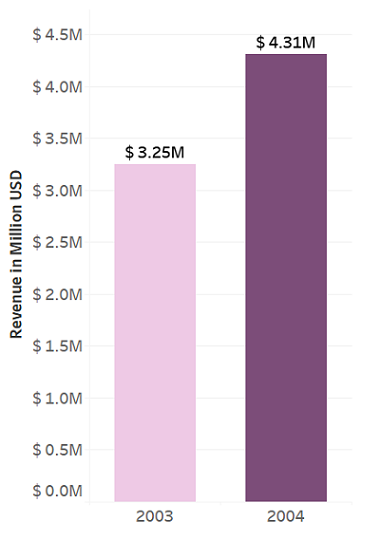

The company's total sales were 4.31 million in 2004 and  3.25 million in  2003. All values are in USD (United States Dollar).

###  Question 3) Which were the best-selling product lines in 2003 and 2004?

To solve this question, we will select only the orders that have were shipped, which will exclude cancelled orders, orders that were 'on hold', 'in process'and on disputes at the date when the database was finished.

In [10]:
best_pl="SELECT p.productline, YEAR(o.orderDate) order_date, SUM(od.quantityordered) total_units,\
                SUM(od.quantityordered*od.PriceEach) total_value\
                FROM products p\
                    JOIN\
                orderdetails od ON p.productCode=od.productCode\
                    JOIN\
                orders o ON o.orderNumber=od.orderNumber\
                WHERE o.status = 'Shipped'\
                AND o.orderDate>='2003-01-01'\
                AND o.orderDate<'2005-01-01'\
                GROUP BY p.productline, YEAR(o.orderDate)\
                ORDER BY YEAR(o.orderDate) ASC, p.productline ASC;"

df_best_pl=pd.read_sql_query(best_pl, con)

df_best_pl

productline  order_date  total_units  total_value
0       Classic Cars        2003      12658.0   1362984.66
1        Motorcycles        2003       3986.0    344998.74
2             Planes        2003       3544.0    284773.21
3              Ships        2003       2557.0    201044.48
4             Trains        2003       1000.0     65822.05
5   Trucks and Buses        2003       3853.0    357094.59
6       Vintage Cars        2003       7715.0    606378.07
7       Classic Cars        2004      15424.0   1682980.21
8        Motorcycles        2004       5976.0    527243.84
9             Planes        2004       5439.0    438255.50
10             Ships        2004       3752.0    292595.34
11            Trains        2004       1290.0     86897.46
12  Trucks and Buses        2004       4853.0    448702.69
13      Vintage Cars        2004      10487.0    823927.95

### Chart 7) Units Sold per Product Line

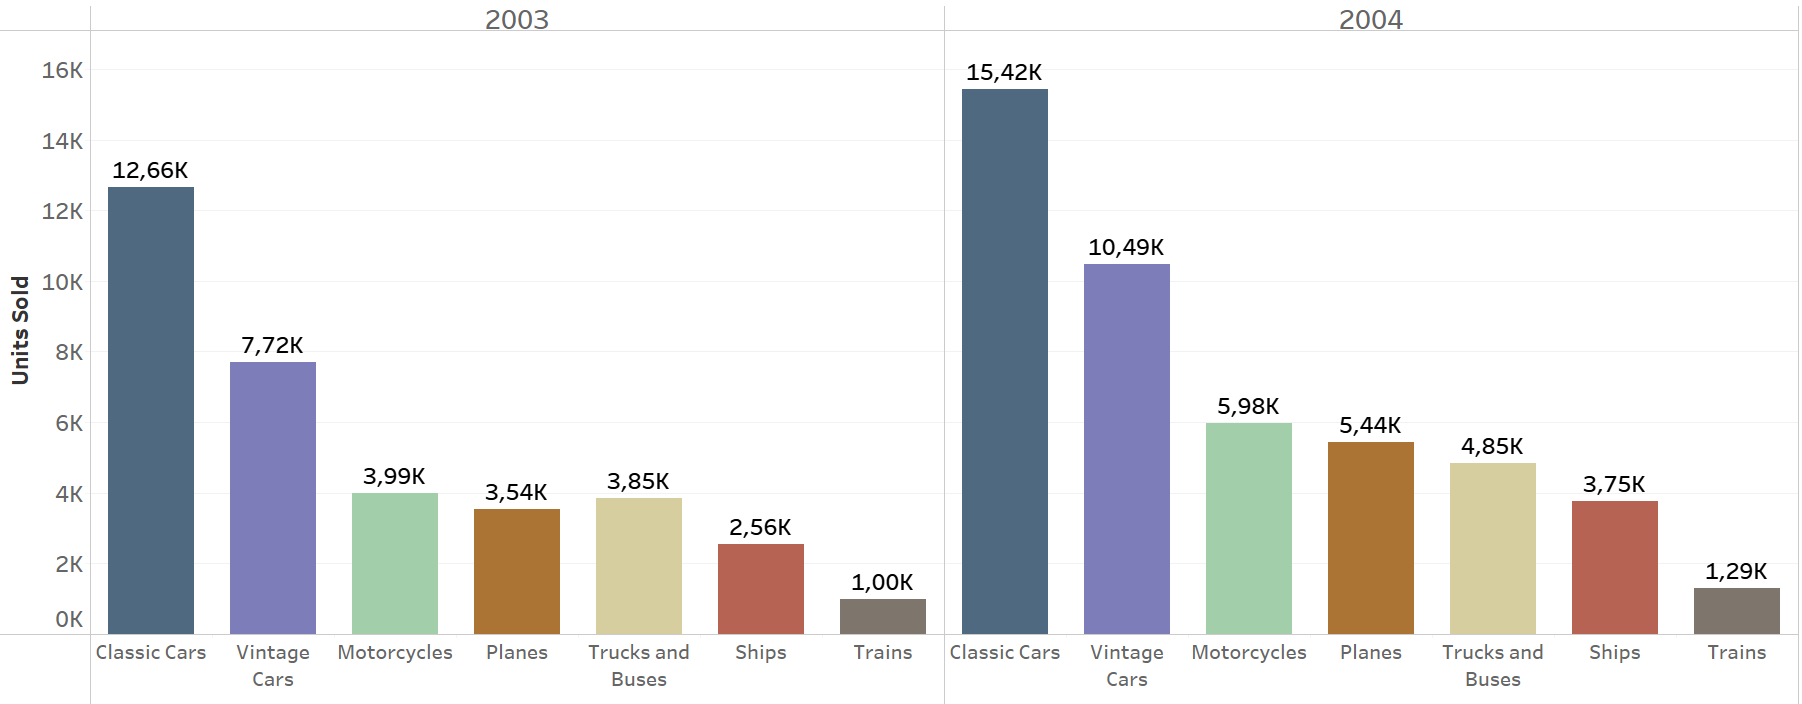

Classic Cars (1st), Vintage Cars (2nd) and Motorcycles (3rd) were the best-selling product lines in 2003 and 2004. In addition, the quantity sold was higher for every product line in 2004, which indicates that the firm is expanding its sales.

Let's test a different form of visualization to indicate the representativeness of each product line:

### Chart 8)  % of each Product Line in Total Units Sold in 2003

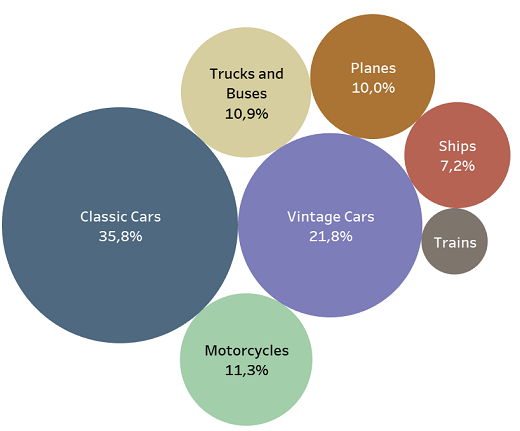

Bubble charts are also an interesting way to compare percentages, quantities and figures within a specific period. Notice that larger bubble sizes represent higher quantities sold. It is relevant to highlight that Classic and Vintage Cars represented around 57,6% of total units sold in 2003. Let's check the percentages for 2004:

### Chart 9)  % of each Product Line in Total Units Sold in 2004

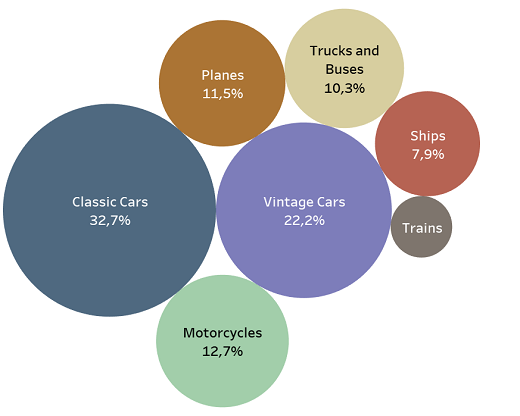

Notice that the representativeness (relative frequencies) of some products slightly varied:

    -Decreased: Classic Cars (- 3,1%), Trucks and Buses (-0,6%) and Trains (-0,3%)
    
    -Increased: Planes (+1,5%), Motorcycles (+1,4%), Ships (+0,7%) and Vintage Cars (+0,4%)

However, we cannot forget that the number of units sold (absolute frequencies) increased considerably in 2004 (+ 33,69%). The aggregated amount in 2003 was around 35,32 K in 2003 and 47,22 K in 2004, which will result in higher sales in terms of monetary units.

###  Question 4) Which were the product lines that generated the highest revenues in 2003 and 2004?

To solve this problem, we can use the same SQL query of the previous question. Let's create a chart to visualize the data:

### Chart 10)  Revenue per Product Line

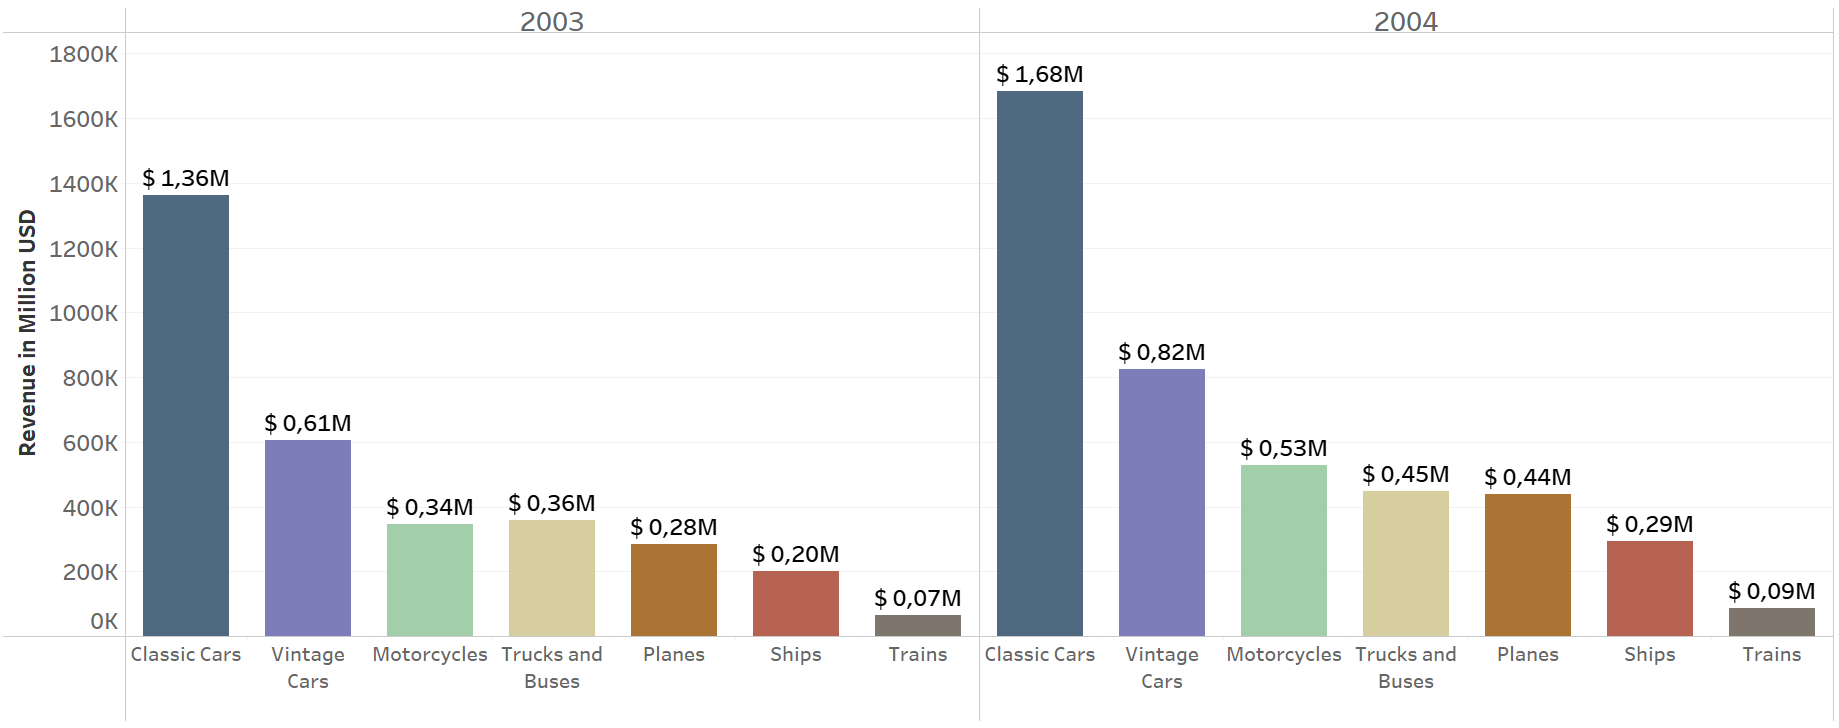

Classic and Vintage Cars are both the best-selling products in terms of units and also, the ones that generate the highest revenues for the company. Nevertheless, from this point on, some relationships change to a certain extent. For instance, even considering that motorcycles were the customers' third favorite product, it occupied the fourth position in the ranking with reference to revenue in 2003. Trucks and Buses were the fitth with regard to units sold, but they were the third in sales in 2003 (in monetary units). Finally, ships and trains are in the same places in both contexts.

### Chart 11) Representativeness of each Product Line in terms of Revenue 

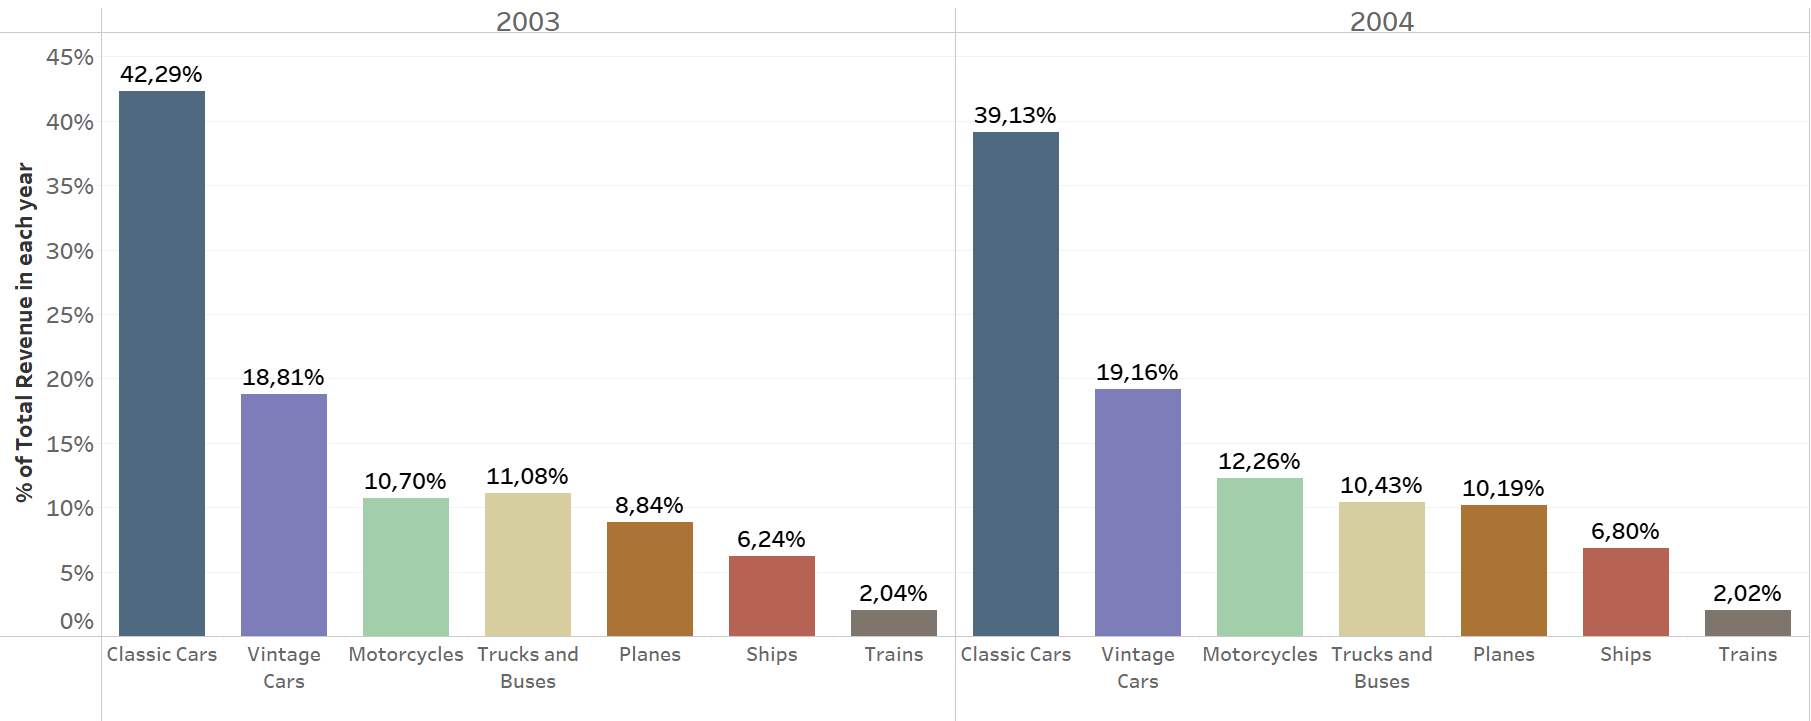

Classic and Vintage Cars represented 61,1% of the firm's revenue in 2003 and 58,29% in 2004. This variation can be explained by the increase in the representativeness of other product lines, for example, motorcycles (+1,56%), planes (+1,35%) and ships (+0,56%).

###  Question 5) What was the average price for each product line in 2003 and 2004?

In [7]:
pl_avg_prices="SELECT p.productline, YEAR(o.orderDate) AS 'Year',AVG(od.priceEach) AS average_price\
                FROM products p\
                    JOIN\
                orderdetails od ON p.productCode=od.productCode\
                    JOIN\
                orders o ON od.orderNumber=o.orderNumber\
                WHERE YEAR(o.orderDate) NOT LIKE '%2005%'\
                GROUP BY p.productline, YEAR(o.orderDate)\
                ORDER BY YEAR(o.orderDate) ASC, AVG(od.priceEach) DESC;"

df_pl_avg_prices=pd.read_sql_query(pl_avg_prices, con)

df_pl_avg_prices

productline  Year  average_price
0       Classic Cars  2003     106.843824
1   Trucks and Buses  2003      93.339818
2        Motorcycles  2003      86.376581
3             Planes  2003      80.738148
4       Vintage Cars  2003      78.877949
5              Ships  2003      78.139877
6             Trains  2003      66.011071
7       Classic Cars  2004     109.274286
8   Trucks and Buses  2004      92.314965
9        Motorcycles  2004      87.725906
10            Planes  2004      80.618512
11      Vintage Cars  2004      78.196903
12             Ships  2004      78.188254
13            Trains  2004      68.257317

### Chart 12) Average Price per Product Line

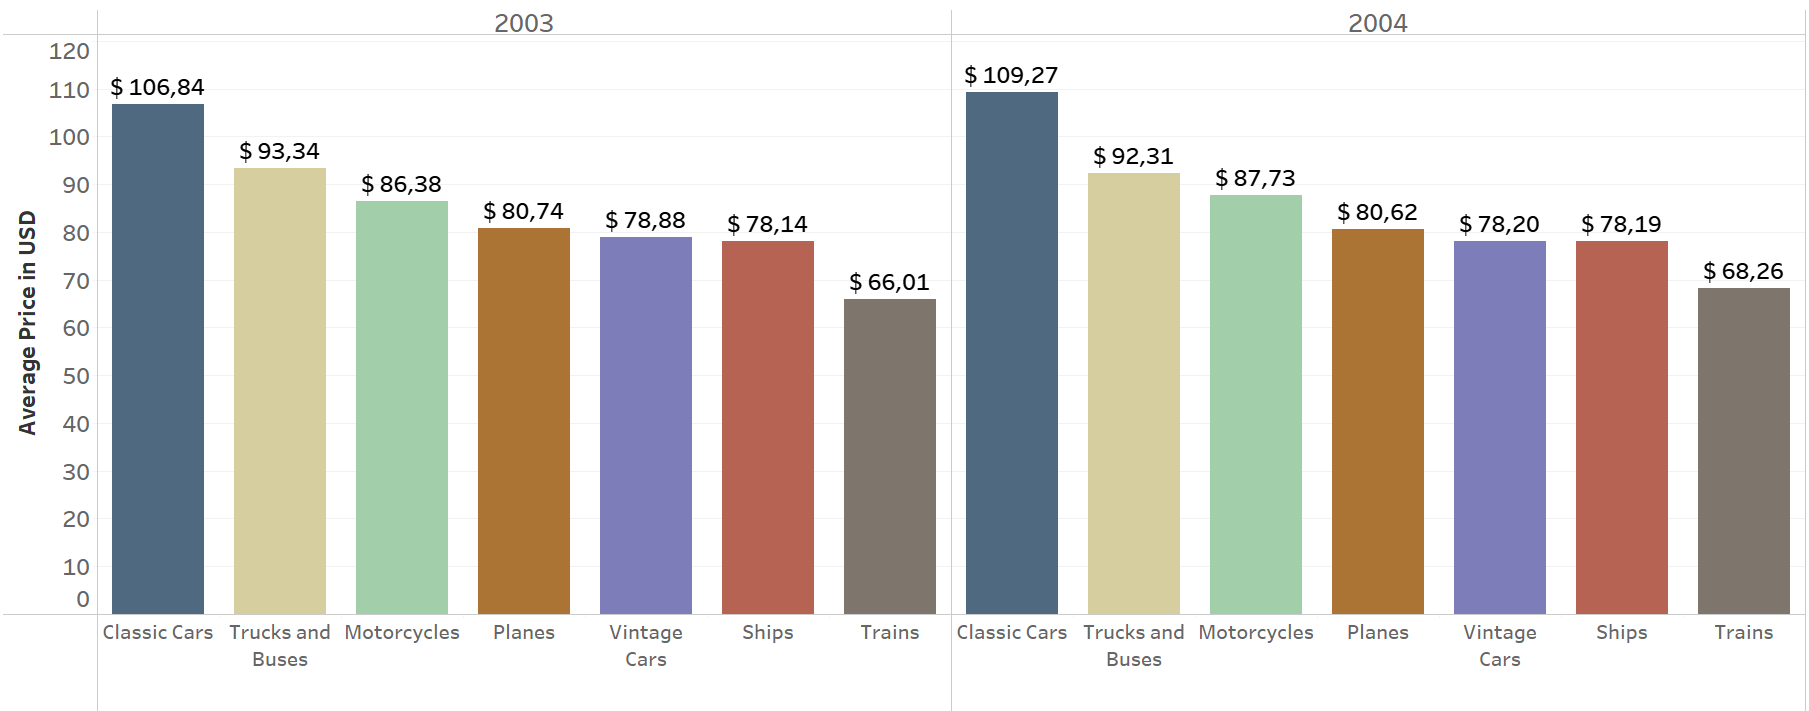

Classic Cars  has the highest average price and it is the company's best-selling product. This explains why classic cars miniatures are the products that generate the highest revenue for the firm. However, something different happens with Vintage Cars. Their average price is around $79/78 dollars in both years (fifth in the ranking), but this product line is the second best in terms of revenue. This is due to the fact that the firm sells much more Vintage Cars (2nd in the quantity sold chart) than other products, like Motorcycles (3rd in the ranking), which compensates for its lower average price. 

### Question 6) If the company wanted to give a reward to the best employee of each year, how would you choose them?

I will use 'LEFT JOINS' so I can also identify the employees that did not sell anything:

In [18]:
all_emp_revenue="SELECT e.employeeNumber, e.firstName, e.lastName, YEAR(py.paymentDate) 'Year', SUM(py.amount) amount_sold\
                FROM employees e\
                    LEFT JOIN\
                customers c ON e.employeeNumber=c.salesRepEmployeeNumber\
                    LEFT JOIN\
                payments py ON c.customerNumber=py.customerNumber\
                GROUP BY e.employeeNumber, e.firstName, e.lastName, YEAR(py.paymentDate)\
                ORDER BY YEAR(py.paymentDate) ASC, SUM(py.amount) DESC;"

df_all_emp_revenue=pd.read_sql_query(all_emp_revenue, con)

df_all_emp_revenue

employeeNumber firstName   lastName    Year  amount_sold
0             1002     Diane     Murphy     NaN          NaN
1             1056      Mary  Patterson     NaN          NaN
2             1076      Jeff   Firrelli     NaN          NaN
3             1088   William  Patterson     NaN          NaN
4             1102    Gerard     Bondur     NaN          NaN
5             1143   Anthony        Bow     NaN          NaN
6             1702    Martin     Gerard     NaN          NaN
7             1286  Foon Yue      Tseng     NaN          NaN
8             1619       Tom       King     NaN          NaN
9             1625   Yoshimi       Kato     NaN          NaN
10            1165    Leslie   Jennings  2003.0    413219.85
11            1401    Pamela   Castillo  2003.0    317104.78
12            1370    Gerard  Hernandez  2003.0    295246.44
13            1621      Mami      Nishi  2003.0    267249.40
14            1501     Larry       Bott  2003.0    261536.95
15            1504     Barry      Jones  2003.0    243847.90
16            1611      Andy     Fixter  2003.0    226808.03
17            1286  Foon Yue      Tseng  2003.0    221887.03
18            1188     Julie   Firrelli  2003.0    220116.97
19            1702    Martin     Gerard  2003.0    179648.58
20            1337      Loui     Bondur  2003.0    177960.10
21            1323    George     Vanauf  2003.0    169288.50
22            1166    Leslie   Thompson  2003.0    119461.28
23            1216     Steve  Patterson  2003.0     81664.41
24            1612     Peter      Marsh  2003.0     55177.48
25            1370    Gerard  Hernandez  2004.0    487510.31
26            1401    Pamela   Castillo  2004.0    409910.07
27            1323    George     Vanauf  2004.0    386617.52
28            1504     Barry      Jones  2004.0    365858.21
29            1612     Peter      Marsh  2004.0    337455.80
30            1216     Steve  Patterson  2004.0    337260.95
31            1165    Leslie   Jennings  2004.0    332370.22
32            1501     Larry       Bott  2004.0    308957.54
33            1337      Loui     Bondur  2004.0    263209.69
34            1286  Foon Yue      Tseng  2004.0    237255.26
35            1702    Martin     Gerard  2004.0    207828.89
36            1166    Leslie   Thompson  2004.0    185038.40
37            1611      Andy     Fixter  2004.0    172377.82
38            1621      Mami      Nishi  2004.0    151761.45
39            1188     Julie   Firrelli  2004.0    129916.12
40            1370    Gerard  Hernandez  2005.0    329247.06
41            1165    Leslie   Jennings  2005.0    244316.48
42            1337      Loui     Bondur  2005.0    128315.96
43            1501     Larry       Bott  2005.0    116158.76
44            1611      Andy     Fixter  2005.0    110199.97
45            1612     Peter      Marsh  2005.0    105273.88
46            1166    Leslie   Thompson  2005.0     43033.35
47            1621      Mami      Nishi  2005.0     38099.22
48            1188     Julie   Firrelli  2005.0     36630.11
49            1216     Steve  Patterson  2005.0     30293.77
50            1286  Foon Yue      Tseng  2005.0     29070.38
51            1323    George     Vanauf  2005.0     28500.78
52            1504     Barry      Jones  2005.0     27966.54
53            1401    Pamela   Castillo  2005.0     23187.02

We can notice that 8 employees did not sell any product. Maybe they were hired by the company close to the end of the date range informed by the database. Also, these employees may not be directly related to sales, for instance, directors, managers of other departmetns, among others. Now, we need need to filter only the results that occurred in the period from 2003 to the end of 2004. So, let's execute another query:

In [19]:
emp_revenue="SELECT e.employeeNumber, e.firstName, e.lastName, YEAR(py.paymentDate) 'Year', SUM(py.amount) amount_sold\
            FROM employees e\
                JOIN\
            customers c ON e.employeeNumber=c.salesRepEmployeeNumber\
                JOIN\
            payments py ON c.customerNumber=py.customerNumber\
            WHERE py.paymentDate>='2003-01-01'\
            AND py.paymentDate<'2005-01-01'\
            GROUP BY e.employeeNumber, e.firstName, e.lastName, YEAR(py.paymentDate)\
            ORDER BY YEAR(py.paymentDate) ASC, SUM(py.amount) DESC;"


df_emp_revenue=pd.read_sql_query(emp_revenue, con)

df_emp_revenue

employeeNumber firstName   lastName  Year  amount_sold
0             1165    Leslie   Jennings  2003    413219.85
1             1401    Pamela   Castillo  2003    317104.78
2             1370    Gerard  Hernandez  2003    295246.44
3             1621      Mami      Nishi  2003    267249.40
4             1501     Larry       Bott  2003    261536.95
5             1504     Barry      Jones  2003    243847.90
6             1611      Andy     Fixter  2003    226808.03
7             1286  Foon Yue      Tseng  2003    221887.03
8             1188     Julie   Firrelli  2003    220116.97
9             1702    Martin     Gerard  2003    179648.58
10            1337      Loui     Bondur  2003    177960.10
11            1323    George     Vanauf  2003    169288.50
12            1166    Leslie   Thompson  2003    119461.28
13            1216     Steve  Patterson  2003     81664.41
14            1612     Peter      Marsh  2003     55177.48
15            1370    Gerard  Hernandez  2004    487510.31
16            1401    Pamela   Castillo  2004    409910.07
17            1323    George     Vanauf  2004    386617.52
18            1504     Barry      Jones  2004    365858.21
19            1612     Peter      Marsh  2004    337455.80
20            1216     Steve  Patterson  2004    337260.95
21            1165    Leslie   Jennings  2004    332370.22
22            1501     Larry       Bott  2004    308957.54
23            1337      Loui     Bondur  2004    263209.69
24            1286  Foon Yue      Tseng  2004    237255.26
25            1702    Martin     Gerard  2004    207828.89
26            1166    Leslie   Thompson  2004    185038.40
27            1611      Andy     Fixter  2004    172377.82
28            1621      Mami      Nishi  2004    151761.45
29            1188     Julie   Firrelli  2004    129916.12

We can see that Leslie Jennings and Gerard Hernandéz were the employees that generated the highest revenue for the company in 2003 and 2004, respectively. Now, let's create a chart to visualize the data:

### Chart 13) Sales per Employee (2003)

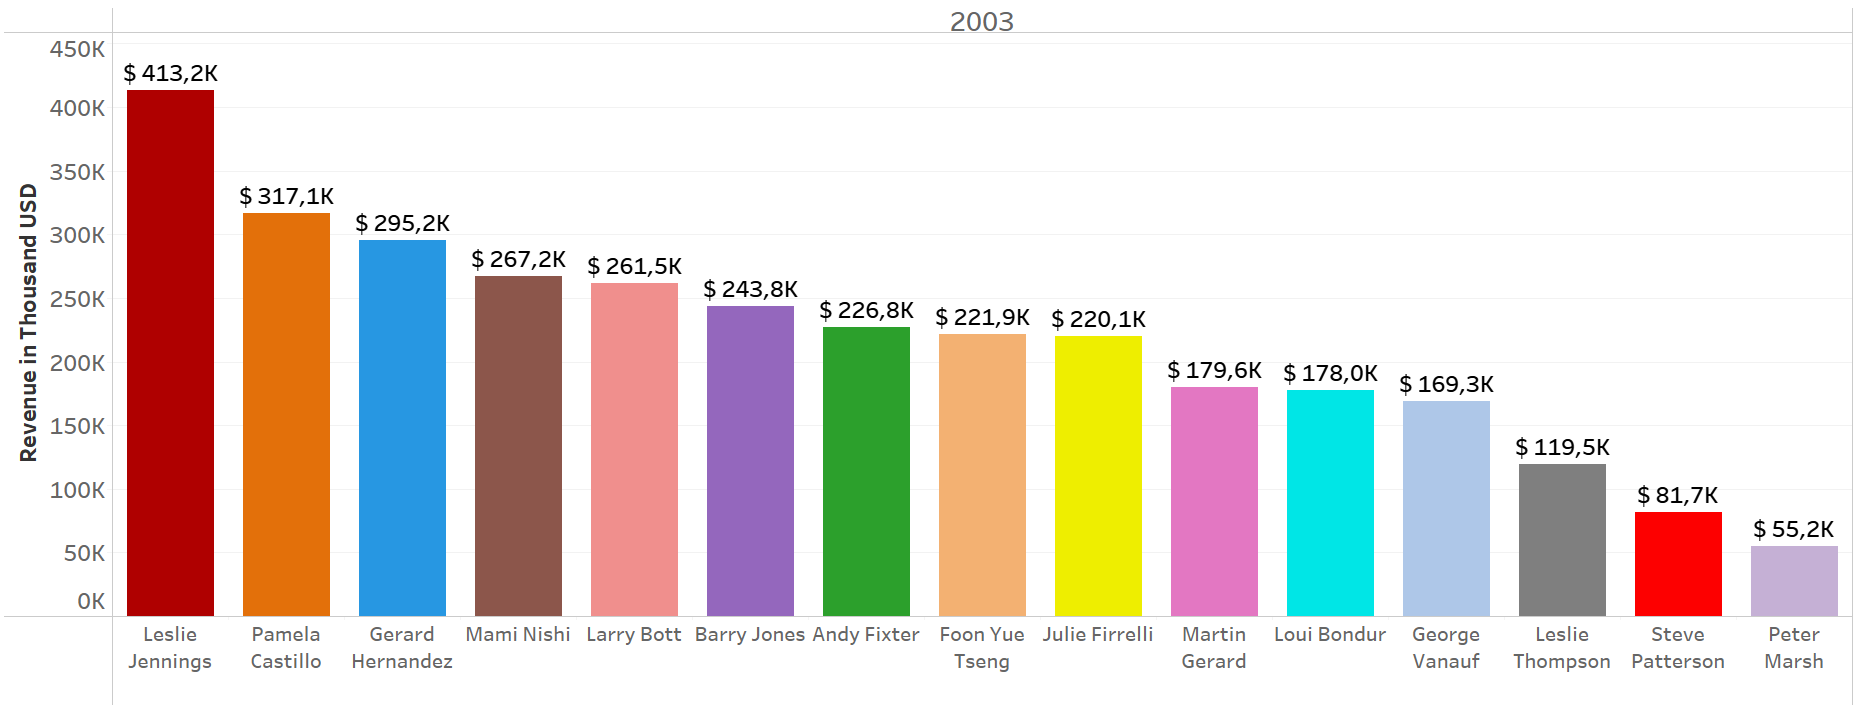

In the following chart, you can find the results for 2004:

### Chart 14) Sales per Employee (2004)

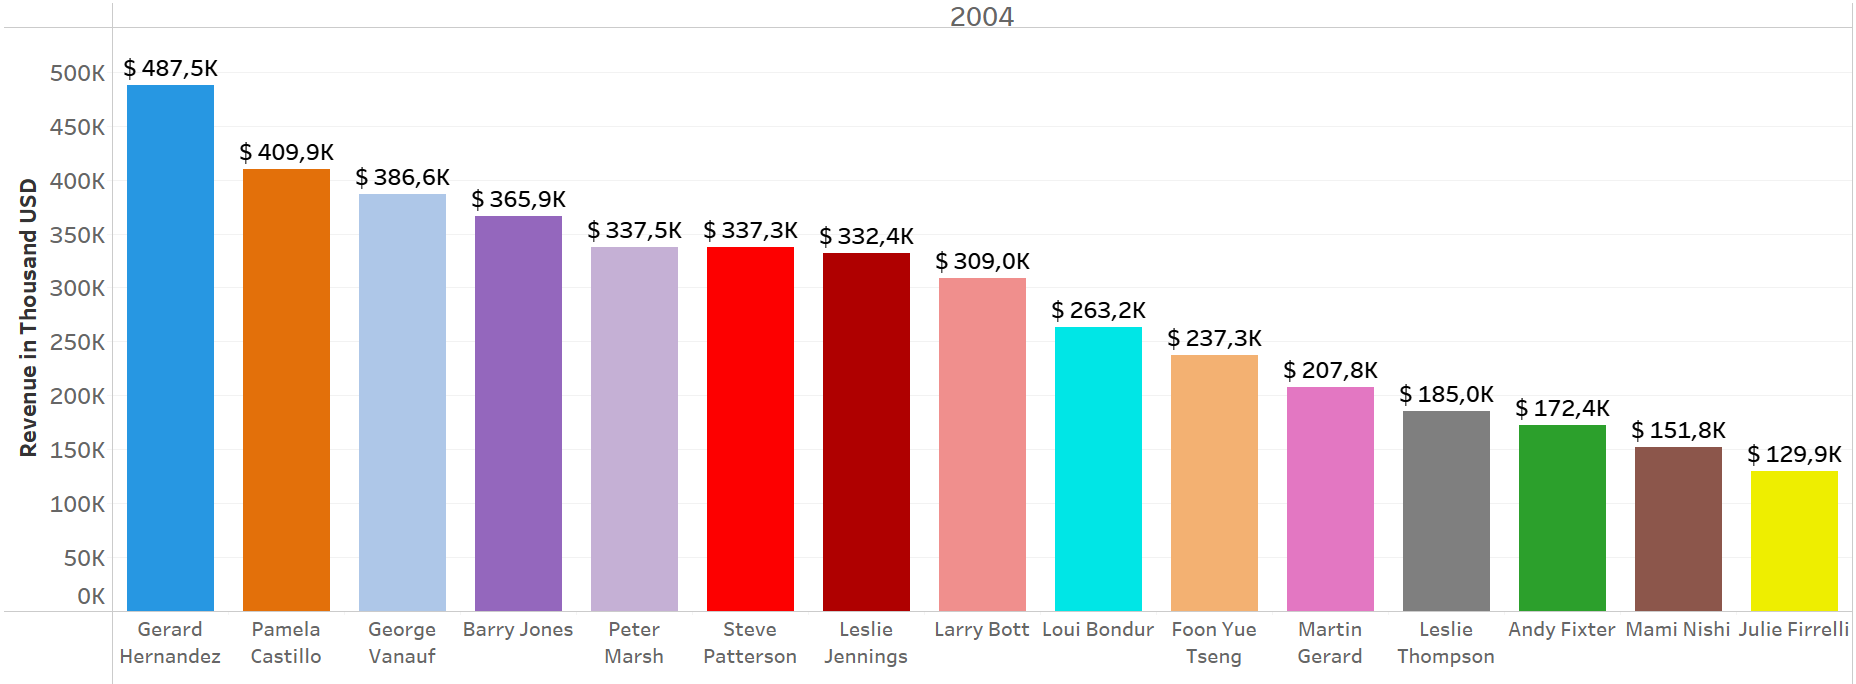

If we use revenue as the only indicator for this analysis, Leslie Jennings and Gerard Herandez were the firm's best employees in 2003 and 2004, respectively. Besides the reward for these two employees, we recommend that the firm also provides a compatible reward for the second place. Pamela Castillo presented an outstanding performance in both years, that is, 317,1 dollars in 2003 and 409,9 dollars in 2004. This is going to motivate her to continue delivering a high-level performance.

### Question 7) The HR department needs to access information about the firm's employees everyday. How can you automate this process?

In order to automate this process, we have to create a stored procedure in MySQL. But first, let's display the 'employees' table:

In [4]:
emp_table="SELECT * FROM employees;"

df_emp_table=pd.read_sql_query(emp_table, con)

df_emp_table

employeeNumber   lastName firstName extension  \
0             1002     Murphy     Diane     x5800   
1             1056  Patterson      Mary     x4611   
2             1076   Firrelli      Jeff     x9273   
3             1088  Patterson   William     x4871   
4             1102     Bondur    Gerard     x5408   
5             1143        Bow   Anthony     x5428   
6             1165   Jennings    Leslie     x3291   
7             1166   Thompson    Leslie     x4065   
8             1188   Firrelli     Julie     x2173   
9             1216  Patterson     Steve     x4334   
10            1286      Tseng  Foon Yue     x2248   
11            1323     Vanauf    George     x4102   
12            1337     Bondur      Loui     x6493   
13            1370  Hernandez    Gerard     x2028   
14            1401   Castillo    Pamela     x2759   
15            1501       Bott     Larry     x2311   
16            1504      Jones     Barry      x102   
17            1611     Fixter      Andy      x101   
18            1612      Marsh     Peter      x102   
19            1619       King       Tom      x103   
20            1621      Nishi      Mami      x101   
21            1625       Kato   Yoshimi      x102   
22            1702     Gerard    Martin     x2312   

                              email officeCode  reportsTo  \
0      dmurphy@classicmodelcars.com          1        NaN   
1    mpatterso@classicmodelcars.com          1     1002.0   
2    jfirrelli@classicmodelcars.com          1     1002.0   
3   wpatterson@classicmodelcars.com          6     1056.0   
4      gbondur@classicmodelcars.com          4     1056.0   
5         abow@classicmodelcars.com          1     1056.0   
6    ljennings@classicmodelcars.com          1     1143.0   
7    lthompson@classicmodelcars.com          1     1143.0   
8    jfirrelli@classicmodelcars.com          2     1143.0   
9   spatterson@classicmodelcars.com          2     1143.0   
10      ftseng@classicmodelcars.com          3     1143.0   
11     gvanauf@classicmodelcars.com          3     1143.0   
12     lbondur@classicmodelcars.com          4     1102.0   
13   ghernande@classicmodelcars.com          4     1102.0   
14   pcastillo@classicmodelcars.com          4     1102.0   
15       lbott@classicmodelcars.com          7     1102.0   
16      bjones@classicmodelcars.com          7     1102.0   
17     afixter@classicmodelcars.com          6     1088.0   
18      pmarsh@classicmodelcars.com          6     1088.0   
19       tking@classicmodelcars.com          6     1088.0   
20      mnishi@classicmodelcars.com          5     1056.0   
21       ykato@classicmodelcars.com          5     1621.0   
22     mgerard@classicmodelcars.com          4     1102.0   

                jobTitle  
0              President  
1               VP Sales  
2           VP Marketing  
3   Sales Manager (APAC)  
4    Sale Manager (EMEA)  
5     Sales Manager (NA)  
6              Sales Rep  
7              Sales Rep  
8              Sales Rep  
9              Sales Rep  
10             Sales Rep  
11             Sales Rep  
12             Sales Rep  
13             Sales Rep  
14             Sales Rep  
15             Sales Rep  
16             Sales Rep  
17             Sales Rep  
18             Sales Rep  
19             Sales Rep  
20             Sales Rep  
21             Sales Rep  
22             Sales Rep

This company has 23 employees, which are distributed in the following way: 17 Sales Representatives, 3 Sales Managers, 2 Vice Presidents and 1 President.

In order to create the desired stored procedure, you can use the code indicated below:

To use a stored procedure, we have to  call it. For that, we have to insert the first and last names of a specific employee, which are the 'input parameters' of this stored procedure. Let's use Leslie Jennings as an example. The code that you should write in MySQL is the following:

So, if an employee of the HR department needs to access information on a particular employee, the only thing he/she will have to do is to call the stored procedure with "CALL emp_info(first Name, last Name)", as the example above. This will make his/her work more efficient and simple.

### Question 8)  Which customers acquired at least 80.000 dollars in products in 2004?

To select the data that we need, we have to execute the next SQL query:

In [22]:
best_customers="SELECT c.customerNumber, c.customerName, YEAR(py.paymentDate) 'Year', SUM(py.amount) payments\
                FROM customers c\
                    JOIN\
                payments py ON c.customerNUmber=py.customerNumber\
                WHERE py.paymentDate>='2003-01-01'\
                    AND py.paymentDate<'2005-01-01'\
                GROUP BY c.customerNumber, c.customerName, YEAR(py.paymentDate)\
                HAVING SUM(py.amount)>=80000\
                ORDER BY YEAR(py.paymentDate) ASC, SUM(py.amount) DESC;"

df_best_customers=pd.read_sql_query(best_customers, con)

df_best_customers

customerNumber                  customerName  Year   payments
0              141        Euro+ Shopping Channel  2003  189840.15
1              124  Mini Gifts Distributors Ltd.  2003  167783.08
2              148       Dragon Souveniers, Ltd.  2003  150123.15
3              151            Muscle Machine Inc  2003  117634.88
4              320           Mini Creations Ltd.  2003   93565.24
5              278                 Rovelli Gifts  2003   89875.60
6              161          Technics Stores Inc.  2003   89418.78
7              321      Corporate Gift Ideas Co.  2003   85559.12
8              167                  Herkku Gifts  2003   85024.46
9              276       Anna's Decorations, Ltd  2003   80101.92
10             141        Euro+ Shopping Channel  2004  293765.51
11             124  Mini Gifts Distributors Ltd.  2004  231562.53
12             114    Australian Collectors, Co.  2004  127155.96
13             298               Vida Sport, Ltd  2004  108777.92
14             166              Handji Gifts& Co  2004  105420.57
15             187                AV Stores, Co.  2004   99984.40
16             157         Diecast Classics Inc.  2004   98509.25
17             146        Saveley & Henriot, Co.  2004   90593.25
18             286          Marta's Replicas Co.  2004   90545.37
19             131             Land of Toys Inc.  2004   85347.32
20             249            Amica Models & Co.  2004   82223.23
21             239  Collectable Mini Designs Co.  2004   80375.24

After analyzing the table above, we can see that 22 customers spent at least 80.000 dollars with the company in 2003 or 2004. In addition, we identified that the 'Euro+ Shopping Channel' and 'Mini Gifts Distributors Ltd.' occupied the first and second positions of the ranking in both years. This means that these customers genereted the highest revenues for the firm between 2003 and 2004.

Let's visualize this data:

### Chart 15) Revenue per customer (2003)

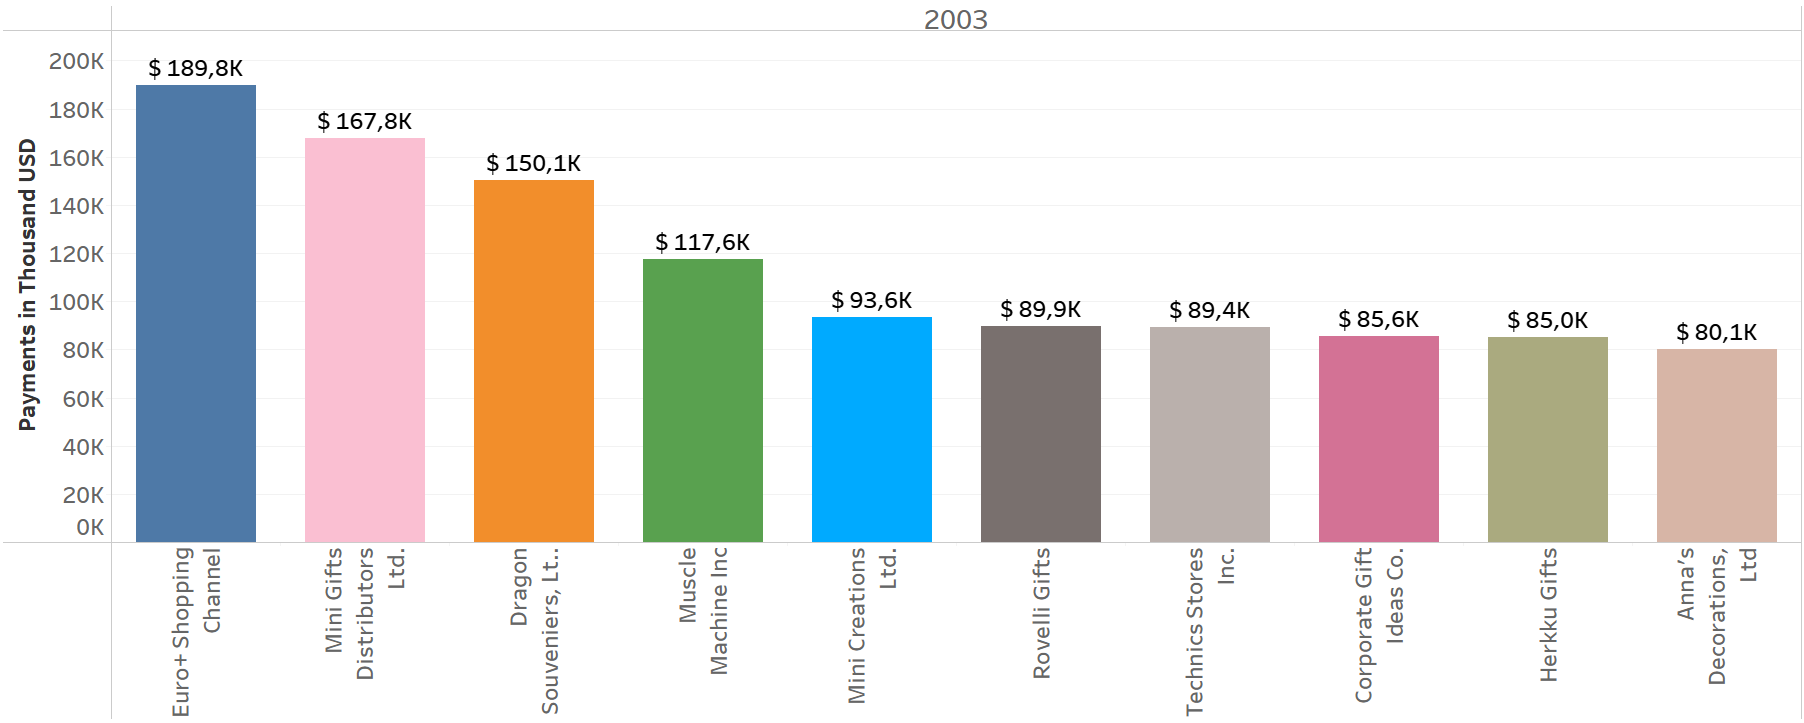

In the next chart, please find the results for 2004:

### Chart 16) Revenue per customer (2004)

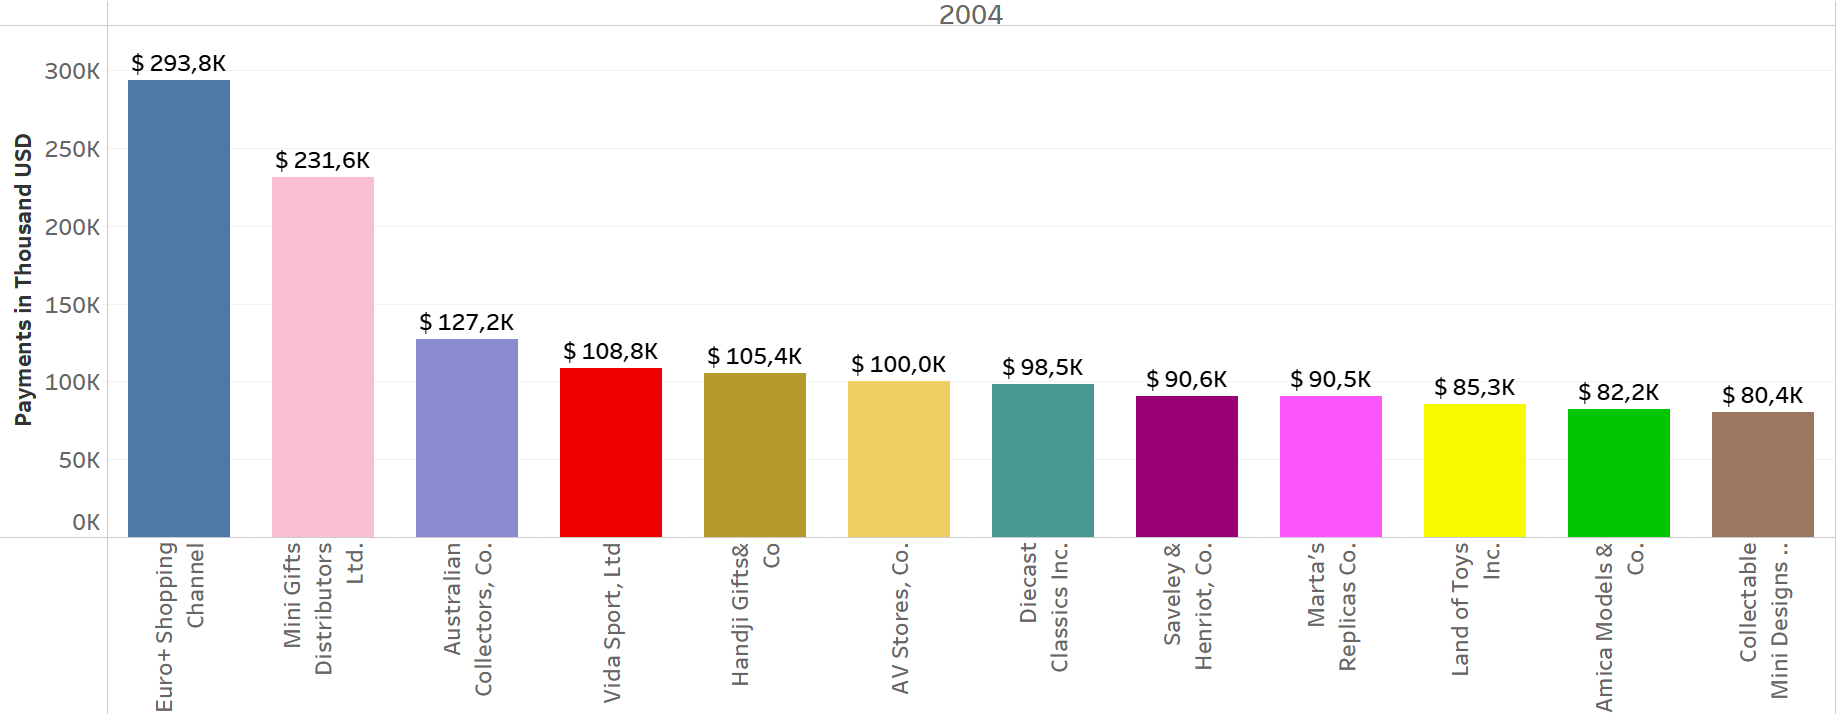

As it was mentioned before, 'Euro+ Shopping Channel' was the company's most important customer, because it acquired 189,8 K and 293,8K in miniatures in 2003 and 2004, respectively. In addition, it is relevant to highlight that 'Mini Gifts Distributors Ltd.' occupied the second post in the ranking in both years. Nevertheless, from the third place onwards, the clients were different in each year. This may indicate that the firm could not retain the customers from 2003. Therefore, the marketing department should structure an action plan to try to maintain clients. For instance, a loyalty program could be created, in order to offer better deals and discounts for these customers. Considering  that they buy miniatures in large quantities to resell them in their retail stores, which enables the firm to concede discounts more easily.

### Question 9)  Are there any cases where the total payments made by customers don't match the total value of their orders?

This situation can happen in different situations. For instance, if a customer cancells an order, it is still going to be registered in the 'orders' and 'orderdetails' tables, but this client is not going to pay for it, which creates a disparity between the amount paid by the customer and the total value of his/her orders. Another possible situations are: some clients may choose to buy something in monthly installments and may have not paid the complete amount yet; maybe some orders are 'on hold' or maybe there is a dispute between the client and the company.

Considering this, now we need to identify which customers paid for all orders they made and which ones did not. For that, we can use the following process:

- Firstly, we need to separate this query into groups (subqueries). This is due to the fact that this process involves many joins between 1:M (one-to-many) pairs. In order to avoid 'combinatorial explosions', we will create two subqueries:

    - The subquery below groups the customer numbers present in the payments table and displays the total value each one of them spent:

In [27]:
subquery_payments="SELECT py.customerNumber, SUM(py.amount) AS payment_amounts\
                FROM\
                    payments py\
                GROUP BY py.customerNumber;"


df_subquery_payments=pd.read_sql_query(subquery_payments, con)

df_subquery_payments

customerNumber  payment_amounts
0              103         22314.36
1              112         80180.98
2              114        180585.07
3              119        116949.68
4              121        104224.79
..             ...              ...
93             486         77726.59
94             487         42570.37
95             489         29586.15
96             495         65541.74
97             496        114497.19

[98 rows x 2 columns]

    - The following subquery groups the customers Numbers and indicates the total value of the orders that were made by each customer, whether they were cancelled or not:

In [28]:
subquery_orders="SELECT o.customerNumber, SUM(od.quantityOrdered * od.priceEach) AS orders_amounts\
                FROM orders o\
                    INNER JOIN\
                orderdetails od ON o.orderNumber=od.orderNumber\
                GROUP BY o.customerNumber;"

df_subquery_orders=pd.read_sql_query(subquery_orders, con)

df_subquery_orders

customerNumber  orders_amounts
0              103        22314.36
1              112        80180.98
2              114       180585.07
3              119       158573.12
4              121       104224.79
..             ...             ...
93             486        77726.59
94             487        42570.37
95             489        29586.15
96             495        65541.74
97             496       137460.79

[98 rows x 2 columns]

Now that we have these two subqueries, we can establish 1:1 (one-to-one) relationships to join 'orders', 'orderdetails', 'customers' and 'payments' tables. 

To identify if a customer paid for all the orders he/she made, please follow the lengend:

- Legend for the column named 'Match':


    - Match: the total amount payed by the client matches the total value of orders.
         
    - Don't match: the total amount payed by the customer does not match the total value of orders. This can happen whether because he/she cancelled an order or simply because he/she did not pay yet. Also, some orders may be 'On hold' or a dispute may have been established between the client and the company.
         
    - NULL: customers who did not make at least one order or one payment in the determined period.

In [4]:
match_payments_orders="SELECT c.customerNumber, py.amount AS payments_amount, orders_amount,\
                    CASE\
                    WHEN py.amount=orders_amount THEN 'Match'\
                    WHEN py.amount IS NULL AND orders_amount IS NULL THEN 'NULL'\
                    ELSE 'Dont Match'\
                    END AS 'Match'\
                    FROM customers c\
                        LEFT JOIN\
                    (SELECT o.customerNumber, SUM(od.quantityOrdered*od.priceEach) orders_amount\
                    FROM orders o\
                        JOIN\
                    orderdetails od ON o.orderNumber=od.orderNumber\
                    GROUP BY o.customerNumber) o ON c.customerNumber=o.customerNumber\
                        LEFT JOIN\
                    (SELECT customernumber, SUM(amount) amount\
                    FROM payments\
                    GROUP BY customerNumber) py ON c.customerNumber=py.customerNumber\
                    ORDER BY py.amount DESC;"

df_match=pd.read_sql_query(match_payments_orders, con)

df_match

customerNumber  payments_amount  orders_amount       Match
0               141        715738.98      820689.54  Dont Match
1               124        584188.24      591827.34  Dont Match
2               114        180585.07      180585.07       Match
3               151        177913.95      177913.95       Match
4               148        156251.03      156251.03       Match
..              ...              ...            ...         ...
117             477              NaN            NaN        NULL
118             480              NaN            NaN        NULL
119             481              NaN            NaN        NULL
120             168              NaN            NaN        NULL
121             376              NaN            NaN        NULL

[122 rows x 4 columns]

Now, let's select only the ones that did not match:

In [35]:
df_dont_match=df_match[df_match['Match']=="Dont Match"]

df_dont_match

customerNumber  payments_amount  orders_amount       Match
0              141        715738.98      820689.54  Dont Match
1              124        584188.24      591827.34  Dont Match
12             119        116949.68      158573.12  Dont Match
14             496        114497.19      137460.79  Dont Match
17             131        107639.94      149085.15  Dont Match
18             145        107446.50      129085.12  Dont Match
20             166        105420.57      107746.75  Dont Match
25             157         98509.25      104358.69  Dont Match
31             282         91655.61      133907.12  Dont Match
33             386         90143.31      125505.57  Dont Match
40             382         85060.00      137480.07  Dont Match
47             448         76776.44      120943.53  Dont Match
63             412         66704.94       90332.38  Dont Match
66             314         62253.85       70851.58  Dont Match
68             201         61167.18      106610.72  Dont Match
70             450         59551.38      143536.27  Dont Match
73             357         56662.38       94431.76  Dont Match
82             471         44920.76       55866.02  Dont Match
84             144         43680.65       66694.82  Dont Match
87             328         38281.51       81806.55  Dont Match
88             362         33533.47       84340.32  Dont Match

In [38]:
df_dont_match['customerNumber'].count()

21

So, this means that the payment values of 21 clients do not match the total value of their orders.

### Thank you!

If you are interested in my work or if you have any feedback, please don't hesitate in contacting me.